***
<p style="text-align:left;">Reinforcement Learning
<span style="float:right;">Monday, 22. June 2020</span></p>

<p style="text-align:left;">Prof. S. Harmeling
<span style="float:right;">DUE 23:55 Monday, 29. June 2020</span></p>

---
<p style="text-align:center;"><b>Exercise set #9</b></p>

---

# REINFORCE

In this exercise you will implement **REINFORCE** with linear policy approximation.  

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import IntProgress

## 2. Small-corridor gridworld

Consider the small-corridor gridworld. The reward is -1 per step. In each of the three non-terminal states there are only two actions, right and left. These actions have their usual consequences in the first and third states (left causes no movement in the first state), but in the second state they are reversed, so that right moves to the left and left moves to the right. 

Implement the environment described above:

In [2]:
class SmallCorridorEnv(gym.Env):
    
    def __init__(self):
        super().__init__()
        self.observation_space = gym.spaces.Discrete(4)
        self.action_space = gym.spaces.Discrete(2)
        self.s = 0
    
    def reset(self):
        self.s = 0
        return self.s
    
    def step(self, action):
        """action: 0 is left, 1 is right"""
        #########################
        # Write your code here. #
        #########################
        done = False
        self.s_ = self.s
        if self.s == 0 or self.s == 2:
            if action == 1:
                self.s_ = self.s + 1
            elif self.s == 2:
                self.s_ = 1
                
        if self.s == 1:
            if action == 1:
                self.s_ = 0
            else:
                self.s_ = 2
        
        r = - 1
        self.s = self.s_
        if self.s == 3:
            done = True
        info = {}
        
        return self.s, r, done, info
    
    def render(self):
        output = ['-'] * 4
        output[self.s] = '*'
        print(''.join(output))

Sanity-check for environment: randomly select actions and render environment

In [3]:
env = SmallCorridorEnv()
env.reset()
env.render()
done = False
while not done:
    a = env.action_space.sample()
    print('Action', a)
    _, r, done, _ = env.step(a)
    env.render() 

*---
Action 0
*---
Action 1
-*--
Action 1
*---
Action 0
*---
Action 1
-*--
Action 1
*---
Action 1
-*--
Action 1
*---
Action 0
*---
Action 0
*---
Action 1
-*--
Action 1
*---
Action 1
-*--
Action 1
*---
Action 1
-*--
Action 0
--*-
Action 1
---*


## 3. REINFORCE with linear policy approximation 

We have not covered the algorithm in the lecture yet, so first make yourself familiar with chapter 13.3  
from [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/the-book-2nd.html) by Sutton and Barto, p. 326ff.

Our problem is difficult because all states appear identical under the function approximation:  
In particular, we define $x(s, \text{right}) = [1, 0]^T$ and $x(s, \text{left}) = [0, 1]^T$, for all s.  
As a function approximator we use soft-max in action preferences

$$\pi(a|\theta) = \dfrac{\exp\theta^T x(a)}{\sum_b \exp\theta^T x(b)}, \text{ where } h(a,\theta)=\theta^T x(a).$$

We initialize $\theta$ with samples from a normal distribution $\mathcal{N}(0,1)$.  
The algorithm is described in Sutton and Barto as follows:

![REINFORCE](https://i.stack.imgur.com/Acbup.png)

Implement the missing parts of the REINFORCE algorithm:

In [49]:
class REINFORCE:
    
    def __init__(self):
        self.x = np.eye(2)  # action state embedding
        self.theta = np.random.randn(2)  # parameter vector
    
    def policy_fun(self, a):
        """Implements soft-max in action preferences"""
        x_a = np.array([1,0]) if a == 1 else np.array([0,1])
        x_b = np.flip(x_a)
        #########################
        pi = np.exp(self.theta @ x_a)/(np.exp(self.theta @ x_b) + np.exp(self.theta @ x_a))
        return pi
        #########################
    
    def ln_policy_grad(self, a):
        """Equation (13.9) from Sutton and Barto"""
        #########################
        x_a = np.array([1,0]) if a == 1 else np.array([0,1])
        x_b = np.flip(x_a)
        b = a == False
        grad = x_a - (self.policy_fun(b) * x_b + self.policy_fun(a) * x_a)
        return grad
        #########################
    
    def sample_action(self):
        """Sample action according to the learned policy"""
        if np.random.uniform() < self.policy_fun(0):
            return 0
        return 1
    
    def rollout(self, env):
        """Sample an episode from the environment starting at initial state"""
        done = False
        s = env.reset()
        r_old = None
        sar = []
        # sar contains tuples (s_t, a_t, r_t) with the indices like in the REINFORCE algorithm
        # from Sutton and Barto in the picture above. Therefore the rewards start in the second
        # tuple and r_0 is None.
        while not done:
            a = self.sample_action()
            s_new, r, done, _ = env.step(a)
            sar.append((s, a, r_old))
            s, r_old = s_new, r
        return sar
    
    def train(self, env, steps=1000, alpha=2**(-13), gamma=0.9):
        """REINFORCE: Monte-Carlo Policy-Gradient Control (episodic)"""
        reward_hist = [] # sum of rewards for each episode
        for i in range(steps):
            sar = self.rollout(env)
            rewards = [r for s, a, r in sar]
            
            for t in range(len(sar)):
                #########################
                G = np.sum([gamma**(k-t-1)*rewards[k] for k in range(t+1, len(sar))])
                self.theta += alpha*(gamma**t)*G*self.ln_policy_grad(sar[t][1])
                #########################
            reward_hist.append(sum(rewards[1:]))
        return reward_hist

### Run the experiment

The following code tests the REINFORCE algorithm on the small-corridor gridworld.  
It computes the sum of the returns for each rollout averaged over 100 runs.
The following parameters will be used:
- step size $\alpha=2^{-13}$, $\gamma=1$, and steps=1000

If you have done everything correctly, the plot should look roughly similar to the red plot in figure 13.1 from Sutton and Barto, p. 328.

IntProgress(value=0)

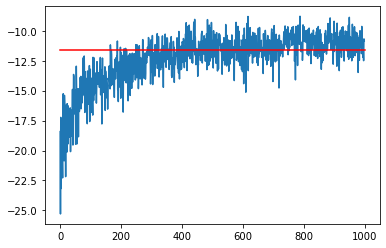

In [50]:
reward_hists = []
right_prob = []
runs = 100
progress = IntProgress(min=0, max=runs)
display(progress)

for i in range(runs):
    env = SmallCorridorEnv()
    agent = REINFORCE()
    reward_hist = agent.train(env, steps=1000, alpha=2**(-13), gamma=1)
    reward_hists.append(reward_hist)
    right_prob.append(agent.policy_fun(1))
    progress.value += 1

progress.bar_style = 'success'

plt.plot(np.array(reward_hists).mean(axis=0))
plt.plot([0, 1000], [-11.6, -11.6], c='r');

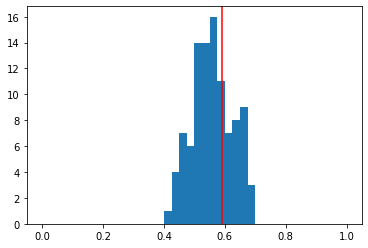

In [51]:
plt.hist(right_prob, bins=40, range=(0,1))
plt.axvline(0.59, c='r');

The best probability is about 0.59, which achieves a value of about -11.6.

In [52]:
np.mean(right_prob)

0.5601639143588149